In [1]:
'''
This cell loads the model from the config file and initializes the viewer
'''
%matplotlib widget
import torch
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from pathlib import Path
import numpy as np
from nerfstudio.viewer.viewer import Viewer
from nerfstudio.configs.base_config import ViewerConfig

# config = Path("outputs/garfield_plushie/dig/2024-03-12_153919/config.yml")#denoised with patch stride 7 and enable_pe
# config = Path("outputs/garfield_plushie/dig/2024-03-12_155712/config.yml")#denoised with stride 7 and no enable_pe
# config = Path("outputs/garfield_plushie/dig/2024-03-12_160428/config.yml")#non-denoised patch size 7
config = Path("outputs/garfield_plushie/dig/2024-03-18_170403/config.yml")#patch size 7 with garfield

# config = Path("outputs/nerfgun/dig/2024-03-12_162138/config.yml")#denoised nerfgun, patch stride 7
# config = Path("outputs/nerfgun/dig/2024-03-12_163729/config.yml") #denoised nerfgun, patch stride 14

# config = Path("outputs/nerfgun2/dig/2024-03-12_165027/config.yml")#nerfgun2 stride 14, denoised
# config = Path("outputs/nerfgun2/dig/2024-03-12_171730/config.yml")#stride 7
# config = Path("outputs/nerfgun2/dig/2024-03-13_151932/config.yml")#stride 7, with garfield

# config = Path("outputs/boops_mug/dig/2024-03-13_141111/config.yml")#denoise stride 7
_,pipeline,_,_ = eval_setup(config)
pipeline.eval()
dino_loader = pipeline.datamanager.dino_dataloader
v = Viewer(ViewerConfig(default_composite_depth=False),config.parent,pipeline.datamanager.get_datapath(),pipeline)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[17:07:13] Auto image downscale factor of 2                                                 ]8;id=478527;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=136999;file:///home/justin/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

[17:07:14] Caching / undistorting train images                                            ]8;id=906399;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=595490;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#182\182]8;;\

Output()

[17:07:16] Caching / undistorting eval images                                             ]8;id=307599;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py\full_images_datamanager.py]8;;\:]8;id=983238;file:///home/justin/nerfstudio/nerfstudio/data/datamanagers/full_images_datamanager.py#196\196]8;;\

Output()

Using cache found in /home/justin/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Using layer norm
denoiser.1.weight loaded
denoiser.1.bias loaded
Dino data shape torch.Size([356, 65, 119, 128])
Loading instance feature model...


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/garfield_plushie/garfield/2024-02-29_165759/nerfstudio_models/step-000029999.ckpt

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/garfield_plushie/dig/2024-03-18_170403/nerfstudio_models/step-000006000.ckpt

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:7007   │
│   Websocket │ ws://0.0.0.0:7007     │
│             ╵                       │
╰─────────────────────────────────────╯

100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


In [84]:
"""
This cell defines a simple pose optimizer for learning a rigid transform offset given a gaussian model, star pose, and starting view
"""
from lerf.dig import DiGModel
from lerf.data.utils.dino_dataloader import DinoDataloader
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig, CameraOptimizer
from copy import deepcopy
from torchvision.transforms.functional import resize
import viser.transforms as vtf
import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur

class RigidPoseOptimizer:
    def __init__(self, dig_model:DiGModel, dino_loader: DinoDataloader):
        self.dig_model = dig_model
        self.cam_optimizer = CameraOptimizer(CameraOptimizerConfig(mode = "SO3xR3", trans_l2_penalty = 0.0, rot_l2_penalty = 0.0),1,'cuda')
        self.dino_loader = dino_loader
        self.dig_model.eval()

    def set_frame(self, rgb_frame:torch.Tensor, init_c2o: Cameras):
        """
        Sets the rgb_frame to optimize the pose for
        rgb_frame: HxWxC tensor image
        init_c2o: initial camera to object transform (given whatever coordinates the self.dig_model is in)
        """
        self.rgb_frame = rgb_frame
        self.init_c2o = deepcopy(init_c2o).to('cuda')
        self.optimizer = torch.optim.Adam(list(self.cam_optimizer.parameters()),lr=0.02)
        self.frame_pca_feats = self.dino_loader.get_pca_feats(rgb_frame.permute(2,0,1).unsqueeze(0)).cuda().squeeze()

    def step(self, niters = 1):
        for i in range(niters):
            self.optimizer.zero_grad()
            c2o = deepcopy(self.init_c2o)
            c2o.camera_to_worlds.requires_grad = True
            c2o.metadata = {'cam_idx':0}
            self.cam_optimizer.apply_to_camera(c2o)
            dig_outputs = self.dig_model.get_outputs(c2o)
            dino_feats = gaussian_blur(dig_outputs["dino"].permute(2,0,1),kernel_size=[13,13]).permute(1,2,0)
            # THIS IS BAD WE NEED TO FIX THIS
            frame_feats = resize(self.frame_pca_feats.permute(2,0,1), (dino_feats.shape[0],dino_feats.shape[1])).permute(1,2,0).contiguous()
            pix_loss = (frame_feats - dino_feats)
            loss = pix_loss.norm()
            loss.backward()
            self.optimizer.step()
        return dig_outputs

cam_pose = pipeline.model.viewer_control.get_camera(300,None,0)
target_frame_rgb = pipeline.model.get_outputs_for_camera(cam_pose)["rgb"]


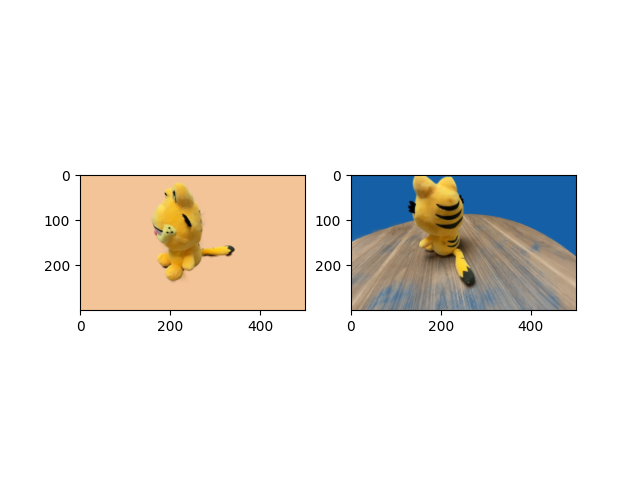

In [85]:
cam_pose = pipeline.model.viewer_control.get_camera(300,None,0)
start_pose_rgb = pipeline.model.get_outputs_for_camera(cam_pose)["rgb"]
_,ax = plt.subplots(1,2)
ax[0].imshow(start_pose_rgb.cpu().numpy())
ax[1].imshow(target_frame_rgb.cpu().numpy())
plt.show()
optimizer = RigidPoseOptimizer(pipeline.model,dino_loader)
optimizer.set_frame(target_frame_rgb,cam_pose)
rgb_renders = []

In [86]:
import moviepy.editor as mpy
import tqdm
for s in tqdm.tqdm(range(200)):
    outputs = optimizer.step(1)
    vis_frame = torch.concatenate([start_pose_rgb,outputs["rgb"],target_frame_rgb],dim=1)
    rgb_renders.append(vis_frame.detach().cpu().numpy()*255)
#save as an mp4
out_clip = mpy.ImageSequenceClip(rgb_renders, fps=30)
out_clip.write_videofile("optimizer.mp4", fps=30)

100%|██████████| 200/200 [00:04<00:00, 47.39it/s]


Moviepy - Building video optimizer.mp4.
Moviepy - Writing video optimizer.mp4



Moviepy - Done !
Moviepy - video ready optimizer.mp4
